# Anti Phishing Classifier

## All imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle


# Metrics for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Read Dataset and X_train Y_train and X_train, X_test

In [2]:
# dataset_url = 'datasets/urlset.csv'
# data = pd.read_csv(dataset_url)
# data = shuffle(data).reset_index(drop=True)
# #data.shape
# labels = data.iloc[:, lambda df: [-1]]
# data = data.loc[:,lambda df:['domain', 'ranking']]
# #labels.shape
# #X_train, X_test, Y_train, Y_test = train_test_split(data, labels, test_size=0.33, random_state=42)
# #X_train.shape
# #X_test.shape

## Read Feature set from already produced features using .ipynb

In [3]:
featureset_with_whois = '../Featureset/whois10000.csv'
data = pd.read_csv(featureset_with_whois)
sscaler = StandardScaler()
#data = sscaler.fit_transform(data)
labels = data.iloc[:, lambda df: [-1]]
data = data.iloc[:,2:-2]

train_data = data.iloc[0:8000,:]
labels_train = labels.iloc[0:8000,:]

test_data = data.iloc[8000:,:]
labels_test = labels.iloc[8000:,:]


# Create features is used to create features for the classification:
'''
1. Domain
2. URL_length
3. URL_slashes_count
4. URL_dots_count
5. URL_hostname_len

'''


In [4]:
def create_features(data_frame):
    url = data_frame['domain']
    len_url = []
    for u in url:
        len_url.append(len(u))

    data_frame['URL_length'] = pd.Series(len_url)
 
    count_slashes = []
    for u in url:
        count_slashes.append(u.count('//') )
    data_frame['URL_slashes_count'] = pd.Series(count_slashes)
    
    count_dots = []
    for u in url:
        count_dots.append(u.count('.') )
    data_frame['URL_dots_count'] = pd.Series(count_dots)

    len_hostname = []
    start = '://'
    end = '/'

    for u in url:
        temp = u[u.find(start)+2*len(start) + 2: u.rfind(end)]
        temp = temp.replace('/','.')
        temp = temp.replace('-','.')
        len_hostname.append(len(temp.split('.')))

    data_frame['URL_hostname_len'] = pd.Series(len_hostname)
    data_frame = data_frame.iloc[:,1:]
    return data_frame
#     total_word_count = 5000
#     tokenizer = Tokenizer(num_words=total_word_count)
#     tokenizer.fit_on_texts(clean_url)

#     seq_length = 5 #Number of items in each sequence
#     sequences = tokenizer.texts_to_sequences(clean_url)
#     data = pad_sequences(sequences, maxlen=seq_length)

#     num_data = phish_data[['create_age(months)', 'expiry_age(months)', 'update_age(days)', 'URL_length', 'URL_slashes', 'URL_dots', 'URL_host']].values
#     num_lab = phish_data["Label"].values

#     sscaler = StandardScaler()
#     num_data_scaled = sscaler.fit_transform(num_data)
#     num_data = num_data_scaled


    

## classify classifies the data in different using all the different  classifiers.

'''
1. Log-Regression
2. K-Nearest Neighbors - @params knn neighbors
3. Decision Tree - @params maximum depth
4. Random Forest - @params maximum depth, criterion, max_features, num_of_estimators
5. AdaBoost

'''

In [5]:
def get_best_clf_after_CrossVal(train_x, train_y, classifier_parameter_map):
    scoring_evals = {'AUC': 'roc_auc',
                     'Accuracy': make_scorer(accuracy_score),
                     'f1': make_scorer(f1_score)
                    }
    clf_list=[]
    for key in classifier_parameter_map:
        clf = GridSearchCV(classifier_parameter_map[key][0],
                     classifier_parameter_map[key][1],
                     #iid=False,
                     scoring = 'accuracy',
                     #refit = 'Accuracy',
                     cv=10, # no of validations
                     n_jobs = -1 # use full concurrency
                    )
        
        result = clf.fit(train_x, train_y)
        #print(clf.cv_results_)
        print(result.best_estimator_)
        print('score: ', result.best_score_)
        clf_list.append(result.best_estimator_)
    return clf_list

In [6]:
 def classify(train_x, train_y):
           
    logreg_parameters = {
     'penalty': ['l1','l2']
    }
    
    knn_parameters = {
       'n_neighbors': np.arange(2,100,1),
       'weights': ['distance'],
       'metric': ['minkowski']
    }
    dt_parameters = {
        'min_samples_split' : range(2,50,2),
        #'max_depth': range(1,50,2)
    }
    
    rf_parameters = {
    'bootstrap': [True],
    'max_depth': range(1,20,1),
    'n_estimators': range(2,100,1)
    }
    
    classifier_parameter_map = {"Log-Regression": (LogisticRegression(), logreg_parameters),
                          "K-Nearest Neighbors": (KNeighborsClassifier(), knn_parameters),
                          "Decision Tree": (DecisionTreeClassifier(), dt_parameters),
                          "Random Forest": (RandomForestClassifier(), rf_parameters)}
                                            #"AdaBoost"}
        
    clf_list = get_best_clf_after_CrossVal(train_x, train_y, classifier_parameter_map)
    print(len(clf_list))
    return clf_list
        
    

In [7]:
clf_list = classify(train_data, np.ravel(labels_train))

/Users/kumar4892/projects/fml/py3venv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)
score:  0.853875
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=16, p=2,
                     weights='distance')
score:  0.89825
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')
score:  0.89975
RandomForestClassifier(bootstra

## Save Models

In [8]:
classifiers = ['Log-Regression', 'K-Nearest Neighbors', 'Decision Tree', 'Random Forest']
for clfname, clf in zip(classifiers, clf_list):
    filename = str('../Model_dump/') + str(clfname) + (str('.sav'))
    pickle.dump(clf, open(filename, 'wb'))

In [9]:
accuracies = []
for clfname, clf in zip(classifiers, clf_list):
    labels_pred = clf.predict(test_data)
    accuracies.append(accuracy_score(labels_test, labels_pred))
    print(clfname)
    print('Accuracy: ', accuracy_score(labels_test, labels_pred))
    print('Classification report')
    print(classification_report(labels_test, labels_pred, target_names=['Spam','Legitimate']))

Log-Regression
Accuracy:  0.8635
Classification report
              precision    recall  f1-score   support

        Spam       0.86      0.88      0.87      1028
  Legitimate       0.87      0.84      0.86       972

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000

K-Nearest Neighbors
Accuracy:  0.9035
Classification report
              precision    recall  f1-score   support

        Spam       0.90      0.92      0.91      1028
  Legitimate       0.91      0.89      0.90       972

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000

Decision Tree
Accuracy:  0.8975
Classification report
              precision    recall  f1-score   support

        Spam       0.89      0.92      0.90      1028
  Legitimate       0.91      0.88      0.89       972

    accuracy 

## Plot

[0.8635, 0.9035, 0.8975, 0.919]


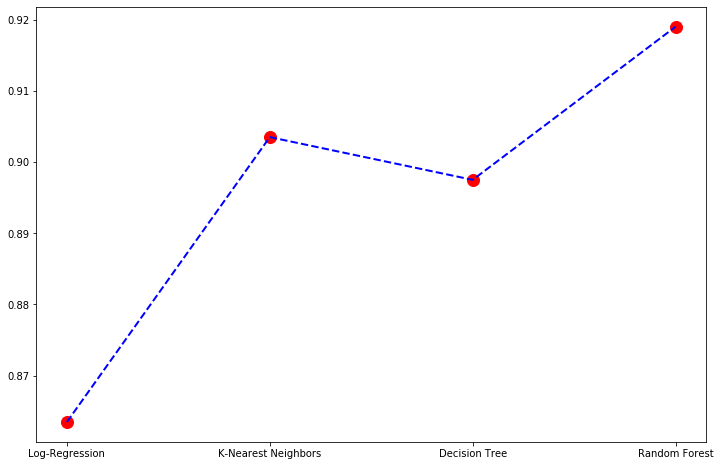

In [10]:
print(accuracies)


plt.figure(figsize=(12, 8))
plt.plot(classifiers, accuracies,'ro',markersize=12)
plt.plot(classifiers, accuracies,color = 'blue', linestyle = 'dashed',linewidth=2, markersize=12)
plt.show()
